In [101]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

LAMBDA_PEN = 1000
L_BOUND = -10
U_BOUND = 10
N_POINTS = 500

num_epochs = 10000

M_POINTS = 5
ALPHA = 2

SELECTION_RATE = 0.01

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [94]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [95]:
def epsilon_Loss(v_x, model_u, upper_bound, discrete_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime_x = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        t = torch.abs(torch.square(u_prime_x)) + v_xi*torch.square(u_xi)

        total += t
    return h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         upper_bound, discrete_points):
    """
    
    """
    eps_sum = 0
    pen = 0
    
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_prime = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        u_xi = model_u(x_i)
        u_xi_square = torch.square(u_xi)

        t = torch.abs(torch.square(u_prime)) + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return epsilon_fn + penalty 

In [50]:
rand_points = np.random.choice(DISCRETE_POINTS, 
                                           size=int(N_POINTS*SELECTION_RATE), 
                                           replace=False)
# print(rand_points)
loss_pen = epsilon_Loss_penalty(p_fn, model, LAMBDA_PEN,
                                        U_BOUND, rand_points)
loss_pen

tensor([5.9242], grad_fn=<AddBackward0>)

In [20]:
epsilon_Loss(potential_fn_class, model, U_BOUND, DISCRETE_POINTS)

tensor([16.2335], grad_fn=<MulBackward0>)

In [21]:
epsilon_Loss_penalty(potential_fn_class, model, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)

tensor([16.6601], grad_fn=<AddBackward0>)

In [51]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1] - discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]
    
    # TRANING MODEL
    def train_network_with_penalty(self, 
                                   num_epochs, 
                                   v_x, 
                                   optimizer, 
                                   lambda_pen, 
                                   discrete_points,
                                   stochastic=True):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            if stochastic == True:
                rand_points = np.random.choice(discrete_points, 
                                               size=int(N_POINTS*SELECTION_RATE), 
                                               replace=False)
                loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                            U_BOUND, rand_points)
                loss = epsilon_Loss(v_x, self,
                                    U_BOUND, rand_points)
            else:
                loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                            U_BOUND, discrete_points)
                loss = epsilon_Loss(v_x, self,
                                    U_BOUND, discrete_points)

            y_loss_pen.append(loss_pen.detach().numpy().item())
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)
        
            if epoch % 100 == 0 or epoch < 30:
                print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        print('Please normalize after training')
        return (x_epochs, y_loss_pen, y_loss)

In [82]:
# For potential function
ti_list = np.random.normal(loc=0, scale=1.0, size= M_POINTS)
ci_list = [(U_BOUND/(i * math.pi))**ALPHA for i in range(1, M_POINTS+1)]


def potential_func_iterative(x, t_list, c_list, M_points=M_POINTS, L_endpoint=U_BOUND, c_0=50):
    f_value = 0
    summation = 0
    #Iterative method:

    for i in range(1, M_points+1):
        cos_val = np.cos((i * math.pi * x)/L_endpoint)
        summation += t_list[i-1] * c_list[i-1] * cos_val

    f_value += summation
    f_value += c_0

    return f_value


def potential_func_linalg(x, M_points=20, L_endpoint=U_BOUND, alpha=3, c_0=100):    
    # Linear Algebra method:
    t_i = np.random.normal(0, 1, size=N_points)
    
    iter1 = ((math.pi/(i*L_endpoint))**alpha for i in range(1, M_points+1))
    c_i = np.fromiter(iter1, float)
    a = np.multiply(t_i, c_i)

    iter2 = (i for i in range(1, M_points+1))
    v = np.fromiter(iter2, float)
    s = (L_endpoint*x/math.pi)*v
    cos_s = np.cos(s)
    
    res_vector = np.multiply(a, cos_s)
    return np.sum(res_vector) + c_0

In [87]:
class Potential_Function:
    def __init__(self, c_0=0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA, 
                 rescale=1):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        self.rescale = 1
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = [(self.L_endpoint/(i * math.pi))**self.alpha for i in range(1, self.M_points+1)]
        
    def forward(self, x):
        f_value = 0
        summation = 0
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0
        return self.rescale * f_value
    
    def set_c0_value(self, val):
        self.c_0 = val
        return
    
    def set_rescale_factor(self, val):
        self.rescale = val
        return 
    
    def update_potential_fn(self, discrete_points):
        # Check lowest value to set appropriate c_0 value:
        y_values = [self.forward(i) for i in discrete_points]
        min_val = min(y_values)
        print("Original min val = " + str(min_val))
        # plt.plot(DISCRETE_POINTS, y_values)

        # Set c_0 value s.t. every value in y_values is > 0: 
        if min_val < 0:
            c_0 = math.ceil(abs(min_val))
            self.set_c0_value(c_0)
            new_y = [self.forward(i) for i in discrete_points]
            print("Min val with c_0 updated = " + str(min(new_y)))
        # plt.plot(DISCRETE_POINTS, new_y)

        # Rescale potential function s.t. every value lies between 0 and 5:
        max_v = max(new_y)
#         min_v = min(new_y)
#         print(max_v, min_v)
#         max_min = max_v-min_v

#         rescaled_y = [(i-min_v)/(max_min) for i in new_y]
#         plt.plot(DISCRETE_POINTS, rescaled_y)

#         c = 5/max_v
#         self.set_rescale_factor(c)
        return

In [35]:
def model_on_interval(nn_model, discrete_points):
    x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in discrete_points]

    model_output = []
    for i in x_vals:
        model_output.append(nn_model(i).detach().numpy().item())
    return model_output

In [ ]:
t_f = Potential_Function(c_0=50)
start = time.time()
r1 = potential_func_iterative(10, t_list=ti_list, c_list=ci_list)
end = time.time()
time1 = end-start
# print(r1)
print(time1)

start = time.time()
r2 = t_f.forward(10)
end = time.time()
time2 = end-start
# print(r2)
print(time2)

In [ ]:
min_val = 0
for i in range(1000):
    t_f = Potential_Function(c_0=30)
    y_p = [t_f.forward(i) for i in DISCRETE_POINTS]
    if min(y_p) <= min_val:
        min_val=min(y_p)
min_val

In [168]:
# start = time.time()
# res1 = x_square(10)
# end = time.time()
# time1 = end-start
# print(time1)

# start = time.time()
# res2 = potential_func_iterative(10)
# end = time.time()
# time2 = end-start
# print(time2)

In [102]:
learningRate = 0.001

#INIT MODEL
model = Nonlinear(20)
model_2 = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()
    model_2.cuda()

# INIT OPTIMIZER CLASS
# SGD:
sgd_optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learningRate, 
                                momentum=0.9)

# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# adam_optimizer_2 = torch.optim.Adam(model_2.parameters(), 
#                                     lr=learningRate, 
#                                     betas=(0.9, 0.999), 
#                                     eps=1e-08, 
#                                     weight_decay=0, 
#                                     amsgrad=False)

In [103]:
# Init. potential function instance
p_fn = Potential_Function()
p_fn.update_potential_fn(DISCRETE_POINTS)

Original min val = -2.2505509937206774
Min val with c_0 updated = 0.7494490062793226


0.7494490062793226


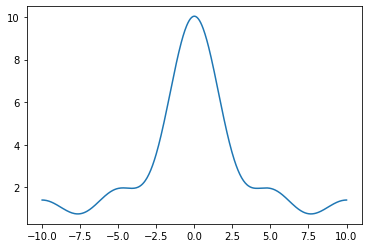

In [104]:
y_p = [p_fn.forward(i) for i in DISCRETE_POINTS]
print(min(y_p))
plt.plot(DISCRETE_POINTS, y_p)

In [ ]:
# Check lowest value to set appropriate c_0 value:
y_values = [p_fn.forward(i) for i in DISCRETE_POINTS]
min_val = min(y_values)
print("Original min val = " + str(min_val))
# plt.plot(DISCRETE_POINTS, y_values)

# Set c_0 value s.t. every value in y_values is > 0: 
c_0 = math.ceil(abs(min_val))
p_fn.set_c0_value(c_0)
new_y = [p_fn.forward(i) for i in DISCRETE_POINTS]

# plt.plot(DISCRETE_POINTS, new_y)

# Rescale potential function s.t. every value lies between 0 and 5:
max_v = max(new_y)
min_v = min(new_y)
print(max_v, min_v)
max_min = max_v-min_v

rescaled_y = [(i-min_v)/(max_min) for i in new_y]
plt.plot(DISCRETE_POINTS, rescaled_y)

In [105]:
### TRAIN MODEL HERE ###
start = time.time()
model_res = model.train_network_with_penalty(num_epochs, 
                                             p_fn, 
                                             adam_optimizer, 
                                             LAMBDA_PEN, 
                                             DISCRETE_POINTS, 
                                             stochastic=True)
end = time.time()
time1 = end-start
print("Using potential function defined as class takes " + str(time1))

epoch 0, loss with penalty 2184.22998046875
epoch 1, loss with penalty 16265.5380859375
epoch 2, loss with penalty 60425.02734375
epoch 3, loss with penalty 35774.6015625
epoch 4, loss with penalty 90.88349151611328
epoch 5, loss with penalty 5501.689453125
epoch 6, loss with penalty 15864.4873046875
epoch 7, loss with penalty 18491.759765625
epoch 8, loss with penalty 1415.222412109375
epoch 9, loss with penalty 9434.4990234375
epoch 10, loss with penalty 6306.21142578125
epoch 11, loss with penalty 8157.919921875
epoch 12, loss with penalty 17847.2109375
epoch 13, loss with penalty 395.0360107421875
epoch 14, loss with penalty 14890.9990234375
epoch 15, loss with penalty 14132.365234375
epoch 16, loss with penalty 6252.49658203125
epoch 17, loss with penalty 338.6435852050781
epoch 18, loss with penalty 12437.8359375
epoch 19, loss with penalty 616.6287231445312
epoch 20, loss with penalty 12082.1455078125
epoch 21, loss with penalty 4641.01953125
epoch 22, loss with penalty 3268.021

In [100]:
model.normalize_model(DISCRETE_POINTS)

Before normalization: 
tensor([[ 0.1132,  0.0441,  0.0100, -0.0986, -0.2150,  0.0661, -0.0105, -0.1129,
          0.2106,  0.1408, -0.0194, -0.0342,  0.1721, -0.0475, -0.0913,  0.1220,
         -0.1335, -0.0022, -0.1952,  0.0809]])
tensor([-0.0364])
After normalization: 
tensor([[ 0.1311,  0.0511,  0.0116, -0.1142, -0.2490,  0.0765, -0.0122, -0.1308,
          0.2440,  0.1631, -0.0224, -0.0396,  0.1994, -0.0550, -0.1058,  0.1413,
         -0.1546, -0.0025, -0.2261,  0.0937]])
tensor([-0.0422])
c value = tensor([1.1583], grad_fn=<MulBackward0>)


<Figure size 432x288 with 0 Axes>

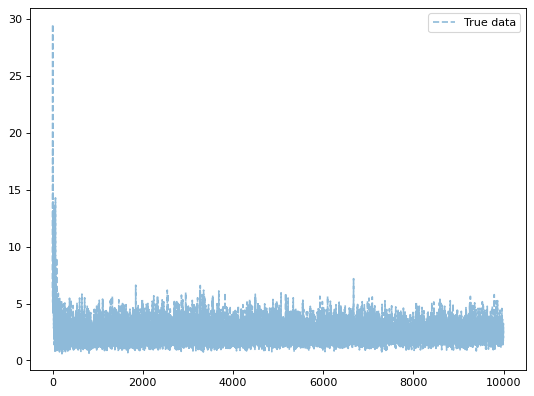

In [106]:
plot_figure(model_res[0], (model_res[2]))

<Figure size 432x288 with 0 Axes>

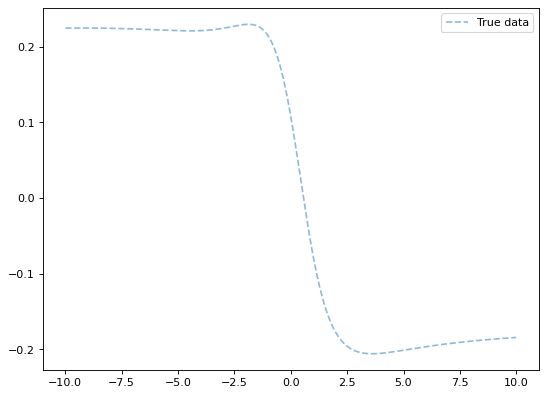

In [107]:
x_values = np.linspace(L_BOUND, U_BOUND, N_POINTS)
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in np.linspace(L_BOUND, U_BOUND, N_POINTS)]

model_output = model_on_interval(model, DISCRETE_POINTS)

plot_figure(x_values, model_output)
# plot_figure(x_values, model_output)

## The Finite Difference Method ##

In [108]:
def fd_method_2(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)
    H = np.zeros((N_points-2,N_points-2))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points-2,N_points-2))
    
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
                
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])
                
    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [109]:
def finite_diff_method(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [110]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    model_output = model_on_interval(nn_model, DISCRETE_POINTS)
    plt.plot(discrete_points, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [111]:
fd_res = finite_diff_method(L_BOUND, U_BOUND, N_POINTS, p_fn)
fd_res2 = fd_method_2(L_BOUND, U_BOUND, N_POINTS, p_fn)
print(fd_res[0])
print(fd_res2[0])

[1.30230216]
[1.30230216]


In [112]:
loss_val = epsilon_Loss(p_fn, model, U_BOUND, DISCRETE_POINTS)
print("The FD method eigenvalue: " + str(fd_res[0][0]))
print("The NN method loss value: " + str(loss_val.item()))

The FD method eigenvalue: 1.302302162576039
The NN method loss value: 2.064028024673462


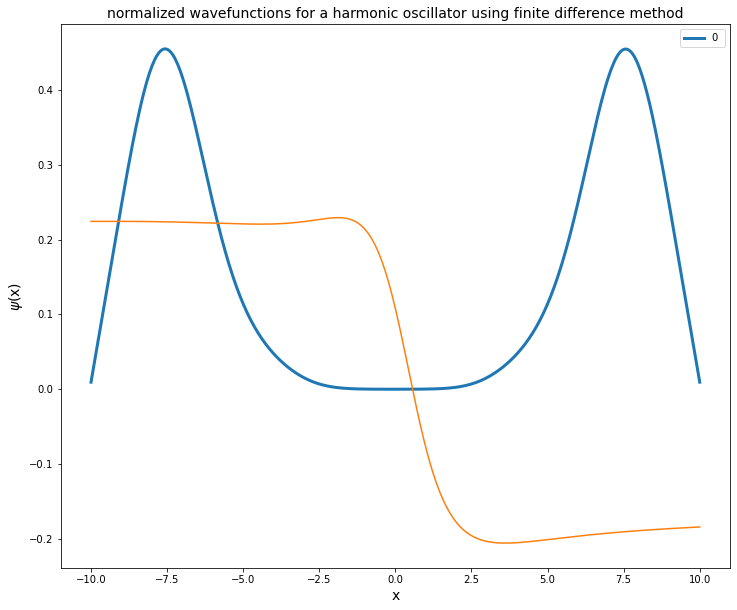

In [113]:
plot_finite_diff_sol(fd_res[0], fd_res[1], DISCRETE_POINTS, model)